# Blog Post Clustering &ndash; Part 2: Comparing Models

In <a href="https://nbviewer.jupyter.org/github/domreichl/blog-post-clustering/blob/master/bp_clustering.ipynb">Part 1</a>, my first notebook on blog post clustering, I used KMeans to cluster the corpus of my *<a href="https://www.mindcoolness.com/">Mindcoolness</a>* blog, analyzed some model predictions, and visualized my data. In this part, I want to compare 4 different models (KMeans, NMF, LSA, LDA) and 3 model combinations (NMF-based KMeans, LSA-based KMeans, LDA-based Kmeans) and evaluate them both qualitatively and quantitatively.

Overview:
1. Modules & Data
2. Vectorization
3. Word Frequency
4. Models & Model Combinations
5. Qualitative Evaluation
6. Quantitative Evaluation

# 1. Modules & Data

This first step simply imports the modules I will use, loads all my blog posts, filters them, and converts the html code into text.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, calinski_harabaz_score

data = pd.read_csv('wp_posts.csv', sep=';')
data = data[(data['post_type'] == 'post') & (data['post_status'] == 'publish')]
data = data[['post_content']].reset_index(drop=True)

for i in data.index:
    soup = BeautifulSoup(data['post_content'].loc[i], 'html.parser')
    data['post_content'].loc[i] = soup.get_text().lower()

data = data['post_content']

# 2. Vectorization

For vectorization, I use *term frequency–inverse document frequency* (tfidf) to penalize high-frequency words with little informational value. The *TfidVectorizer* not only converts words into numbers, but also ensures that the terms defining a cluster provide enough differentiation. For example, the frequency of terms like 'the', 'a', 'is', and 'and' is likely to be high in any English corpus, so they’re of little value for document clustering. A clustering algorithm will produce much better results if the term frequency (how often a word appears in a blog post) is multiplied by the inverse document frequency (a measure of how much information the word provides). This is precisely what the *TfidVectorizer* does.

The *CountVectorizer*, by contrast, uses a simple bag-of-words approach where each term is transformed into a vector based on its frequency. This is useful for plotting the top 20 words in my data, and it's also needed for Latent Dirichlet Allocation (LDA), a structured probabilistic model.

In [2]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(data)
words = vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(stop_words='english')
tf = tf_vectorizer.fit_transform(data)
tf_words = tf_vectorizer.get_feature_names()

# 3. Word Frequency

To visualize the frequency of words in my data set, I first retrieve each term and its count (vector sum) from the vocabulary, then sort all terms by count, and build a list with the 20 most frequent words as well as a list with their counts. Finally, I plot these lists in a bar chart. (Note that the most common English words were already filtered out as stop words during vectorization.)

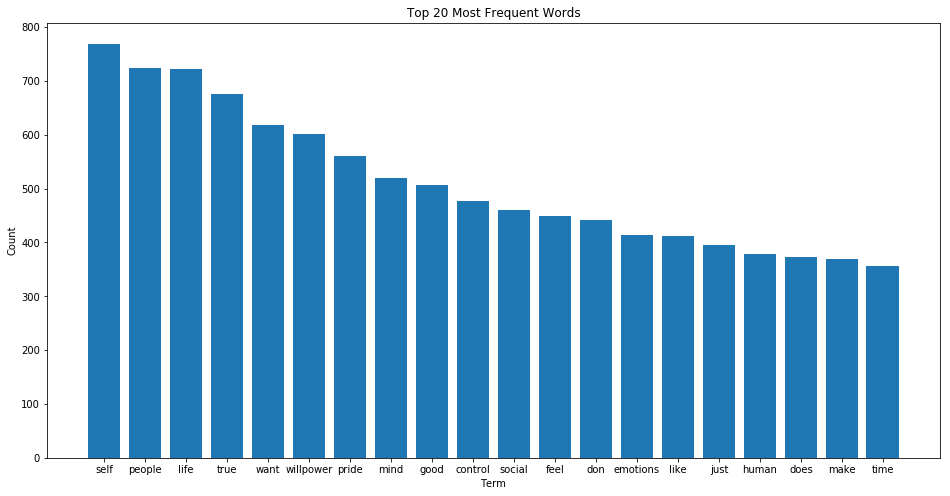

In [3]:
term_frequency = [(term, tf.sum(axis=0)[0, i]) for term, i in tf_vectorizer.vocabulary_.items()]
term_frequency = sorted(term_frequency, key = lambda x: x[1], reverse=True)
terms, count = [], []
for t in term_frequency[:20]:
    terms.append(t[0])
    count.append(t[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(terms)), count)
ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms)
ax.set_title('Top 20 Most Frequent Words')
ax.set_xlabel('Term')
ax.set_ylabel('Count')
plt.show()

# 4. Models & Model Combinations

To detect the main topics of my blog posts, I compare how they are clustered by four different models and three model combinations:
1. NMF for <a href="https://en.wikipedia.org/wiki/Non-negative_matrix_factorization">Non-negative Matrix Factorization</a> (see <a href="https://smartech.gatech.edu/handle/1853/20058">Kim & Park, 2008</a>)
2. TruncatedSVD for <a href="https://en.wikipedia.org/wiki/Latent_semantic_analysis">Latent Semantic Analysis</a> (LSA)
3. LatentDirichletAllocation for <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation">Latent Dirichlet Allocation</a> (LDA)
4. KMeans for <a href="https://en.wikipedia.org/wiki/K-means_clustering">k-means clustering</a>
5. NMF-based Kmeans
6. LSA-based Kmeans
7. LDA-based Kmeans (see <a href="https://www.semanticscholar.org/paper/K-means-Document-Clustering-Based-on-Latent-Guan/9e623a64d1d3f8f73bfedc855c3b8f6861eea591">Guan, 2016</a> and <a href="https://link.springer.com/chapter/10.1007/978-3-319-54472-4_24">Bui et. al, 2017</a>)

In [4]:
k = 4 # number of clusters/components

nmf = NMF(k)
nmf_matrix = nmf.fit_transform(tfidf)

lsa = TruncatedSVD(k)
lsa_matrix = lsa.fit_transform(tfidf)

lda = LatentDirichletAllocation(k, learning_method='batch')
lda_matrix = lda.fit_transform(tf)

km = KMeans(n_clusters=k).fit(tfidf)

km_nmf = KMeans(k).fit(nmf_matrix)

km_lsa = KMeans(k).fit(lsa_matrix)

km_lda = KMeans(k).fit(lda_matrix)

# 5. Qualitative Evaluation

For qualitative evaluation, I look at the three words that were most defining for each cluster produced by a model. If the word combinations make sense (i.e., if all top words of a cluster belong to a distinct category) and if there's little topical overlap between clusters, I will judge the model as good.

The printing function *top_words_decomp* extracts the top three words of each cluster from the components of the decomposition models, whereas function *top_words_cluster* gets the top words from the cluster centers of the KMeans models.

In [5]:
def top_words_decomp(model_name, model, terms):
    print(model_name)
    for i, topic in enumerate(model.components_):
        print("Cluster %d: " % (i), end="")
        print(" ".join([terms[t] for t in topic.argsort()[:-4:-1]]))
    print()

top_words_decomp(" ---NMF---", nmf, words)
top_words_decomp(" ---LSA---", lsa, words)
top_words_decomp(" ---LDA---", lda, tf_words)
    
def top_words_cluster(model_name, centers):
    print(model_name)
    for i in range(k):
        print("Cluster %d: " % i, end="")
        print(" ".join([words[c] for c in centers[i, :3]]))
    print()

top_words_cluster(" ---K-M---", km.cluster_centers_.argsort()[:, ::-1])
top_words_cluster(" ---NMF-KM---", nmf.inverse_transform(km_nmf.cluster_centers_).argsort()[:, ::-1])
top_words_cluster(" ---LSA-KM---", lsa.inverse_transform(km_lsa.cluster_centers_).argsort()[:, ::-1])

 ---NMF---
Cluster 0: meditation mindfulness flow
Cluster 1: moral values meaning
Cluster 2: pride humility ego
Cluster 3: emotions willpower control

 ---LSA---
Cluster 0: pride self true
Cluster 1: moral values meaning
Cluster 2: pride humility ego
Cluster 3: emotions willpower control

 ---LDA---
Cluster 0: pride don want
Cluster 1: willpower brain body
Cluster 2: self willpower control
Cluster 3: life true mind

 ---K-M---
Cluster 0: moral meaning values
Cluster 1: mind meditation freedom
Cluster 2: willpower control emotions
Cluster 3: pride true goal

 ---NMF-KM---
Cluster 0: willpower emotions control
Cluster 1: moral values meaning
Cluster 2: life meditation mindfulness
Cluster 3: pride humility ego

 ---LSA-KM---
Cluster 0: life mindfulness meditation
Cluster 1: willpower emotions control
Cluster 2: moral meaning values
Cluster 3: pride humility true



From what I know about the data, consisting of my own blog posts (hence easy for me to interpret), the NMF clusters are certainly the best. Their top three words neatly outline precisely the very topics I have written about the most on my blog:
- Mindfulness
- Ethics
- The Psychology of Pride
- Willpower for Self-Control

Using NMF in combination with KMeans didn't seem to make much of a difference (only 'life' instead of 'flow'), whereas KMeans alone produced somewhat worse results ('pride true goal' is not as cohesive as 'pride humility ego').

The LSA clusters are the same as those of NMF, except for Cluster 0, which contains less incisive terms and even a duplicate ('pride' is in cluster 0 and 2). Together with KMeans, LSA produced almost the exact same results as the NMF-KMeans combo.

LDA seems to be the worst model: 'willpower' occurs twice, 'pride don want' doesn't clearly delineate a topic, and 'life true mind' is also not particularly expressive.

# 6. Quantitative Evaluation

For quantitative evaluation, I use three metrics that don't require ground truth labels:
1. *Silhouette* is a coefficient that measures consistency within clusters; it should be non-negative and the closer to 1 the better.
2. *WCSS* or *inertia* means within-cluster sum-of-squares, which measures cluster compactness; the smaller the better.
3. *Calinski-Harabasz* is an index calculated as the ratio of between-clusters dispertion and within-cluster dispersion, thus measuring both denseness and separateness of clusters; the larger the better.

In [6]:
evaluation = pd.DataFrame({'Model': ['km', 'km_nmf', 'km_lsa', 'km_lda']})

sc, wcss, chi = [], [], []
for model in (km, km_nmf, km_lsa, km_lda):
    sc.append(silhouette_score(tfidf.toarray(), model.labels_))
    wcss.append(round(model.inertia_, 2))
    chi.append(round(calinski_harabaz_score(tfidf.toarray(), model.labels_), 2))
    
sc[-1] = silhouette_score(tf.toarray(), km_lda.labels_)

evaluation['Silhouette'] = sc
evaluation['WCSS'] = wcss
evaluation['Calinski-Harabasz'] = chi
evaluation.head()

,Model,Silhouette,WCSS,Calinski-Harabasz
0,km,0.009446,296.50,3.26
1,km_nmf,0.011018,2.12,3.87
2,km_lsa,0.011971,6.08,3.86
3,km_lda,-0.023403,26.36,1.97


Although these stats aren't particularly impressive (e.g., all silhouette coefficients are almost zero), their relative values seem to be quite diagnostic:
1. NMF-based KMeans is the best (second-highest SC, lowest WCSS, and highest CHI).
2. LSA-based KMeans is a close second.
3. KMeans alone is not quite as good.
4. LDA-based KMeans is the loser (negative SC, high WCSS, low CHI).

This thoroughly confirms the above quantitative analysis.